In [11]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random


Функция создания графа

In [2]:
def create_graph(graph, n, m):
    nodes = list(range(n))
    graph.add_nodes_from(nodes)
    edges = []
    if m > n*(n-1)/2:
        m = n*(n-1)/2
    while len(edges) != m:
        nodes1 = nodes.copy()
        n1 = random.choice(nodes1)
        nodes1.pop(n1)
        n2 = random.choice(nodes1)
        if (n1, n2) not in edges and (n2, n1) not in edges:
            edges.append((n1, n2))
    graph.add_edges_from(edges)


Функция нахождения эпицентров в графе

In [3]:
def detect_epicenters(curr_load, max_load):
    return [i for i in range(len(curr_load)) if curr_load[i] >= max_load[i]]


Функция отрисовки графа

In [4]:
def draw(graph, curr_load, max_load, i=0):
    epicenters = detect_epicenters(curr_load, max_load)
    if len(graph.nodes) > 0:
        plt.figure(i, figsize=(7, 7))
        pos = nx.circular_layout(graph)
        labels = {}
        pos_higher = {}
        for node in graph.nodes():
            labels[node] = round(curr_load[node], 2)
            pos_higher[node] = (pos[node][0], pos[node][1]+0.2)

        nx.draw(graph,
                pos,
                node_color='orange',
                node_size=800,
                with_labels=True)
        nx.draw_networkx_labels(graph,
                                pos_higher,
                                labels=labels,
                                bbox=dict(facecolor='white',
                                          edgecolor='Lavender', pad=5.0)
                                )
        if len(epicenters) > 0:
            nx.draw_networkx_nodes(graph,
                                   pos,
                                   nodelist=epicenters,
                                   node_size=500,
                                   alpha=0.7,
                                   linewidths=4,
                                   node_color="red")
        x_values, y_values = zip(*pos.values())
        y_max = max(y_values)
        y_min = min(y_values)
        y_margin = 0.5
        plt.ylim(y_min - y_margin, y_max + y_margin)


Основная функция нагрузки системы

In [5]:
# k - количество эпицентров в начальный момент, draw_process - иллюстрировать процесс
def overload_system(graph, curr_load, max_load, k, draw_process=False):
    # создание эпиентров нагрузки
    epicenters = np.random.choice(range(n), k, replace=False)
    for epi in epicenters:
        curr_load[epi] = max_load[epi]
    i = 0   # количество итераций
    while len(epicenters) > 0 and nx.is_k_edge_connected(graph, k=1) and len(graph.nodes) > 0:  # проверка критериев отказа
        if draw_process:
            draw(graph, curr_load, max_load, i)
        epicenters = detect_epicenters(curr_load, max_load)
        i += 1
        for epi in epicenters:  # поиск связанных узлов для будущего распределение нагрузки
            connected_nodes = []
            for edge in graph.edges():
                if epi in edge:
                    connected_node = edge[1 - edge.index(epi)]
                    if curr_load[connected_node] != -1:
                        connected_nodes.append(connected_node)

            delta = curr_load[epi] / len(connected_nodes)
            curr_load[epi] = -1
            for ed in connected_nodes:  # распределение нагрузки
                curr_load[ed] += delta
        graph.remove_nodes_from(epicenters)
    # возвращение наличия связанности и времени
    return nx.is_k_edge_connected(graph, k=1), i


In [6]:
n = 20   # количество вершин
m = 50   # количество рёбер
max_load = np.full(n, 10)  # максимальная загруженность
curr_load = np.random.randint(1, 8, size=(n)).astype(
    float)  # текущая загруженность
graph = nx.Graph()
# проверка на изначальную связанность
while not nx.is_k_edge_connected(graph, k=1):
    create_graph(graph, n, m)


In [7]:
graph1 = graph.copy() # создание копии графа, чтобы основной граф не менялся


Нагрузка 2-мя эпицентрами

Система не вышла из строя


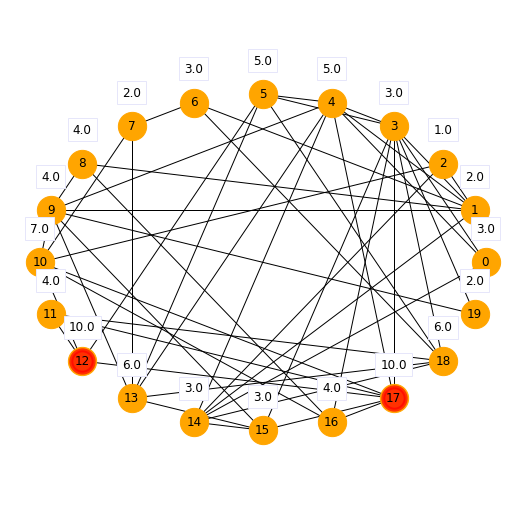

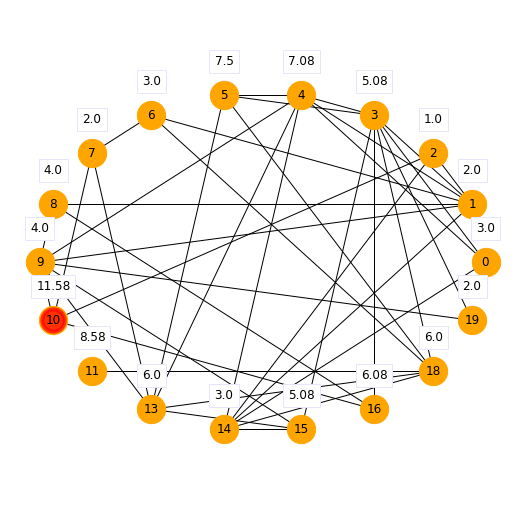

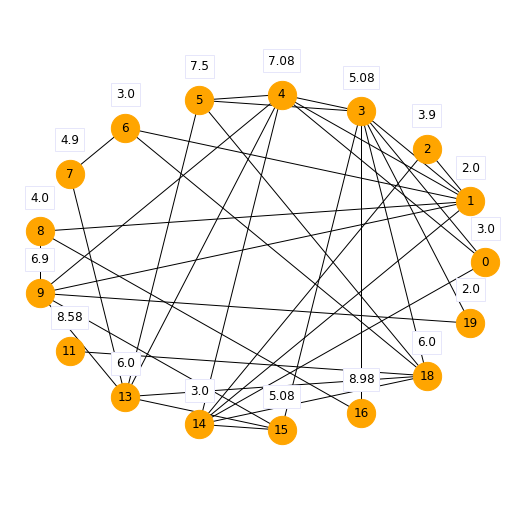

In [8]:
res = overload_system(graph1, curr_load, max_load, 2, True)
if not res[0]:
    print(f"Система вышла из строя за количество итераций равное {res[1]}")
else:
    print("Система не вышла из строя")


Сбор статистики

In [9]:
number_of_epicenters = 10  # максимальное количество эпицентров для статистики
points_y = []
points_x = []
for i in range(1, number_of_epicenters+1):
    points_x.append(i)
    graph1 = graph.copy()
    res = overload_system(graph1, curr_load, max_load, i, False)
    while not res[0]:
        graph1 = graph.copy()
        res = overload_system(graph1, curr_load, max_load, i, False)
    points_y.append(res[1])


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars


Визуализация статистики

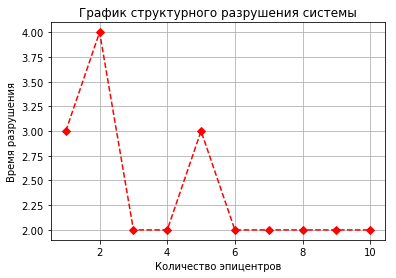

In [10]:
plt.xlabel('Количество эпицентров')
plt.ylabel('Время разрушения')
plt.title('График структурного разрушения системы')
plt.grid(True)
plt.plot(points_x, points_y, '--Dr')
